# XGBoost Classifier (Ensemble)
## Dataset: Heart Disease UCI

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

### 2. Load and Preprocess Data

In [2]:
# Load Heart Disease UCI dataset
df = pd.read_csv('../heart_disease_uci.csv')

print("Original Dataset Shape:", df.shape)
df.head()

Original Dataset Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
# Drop id and dataset columns
df = df.drop(['id', 'dataset'], axis=1)

# Handle missing values
df = df.dropna()
print(f"Dataset Shape after dropping missing values: {df.shape}")

Dataset Shape after dropping missing values: (299, 14)


In [4]:
# Convert target to binary
df['target'] = (df['num'] > 0).astype(int)
df = df.drop('num', axis=1)

print("Target Distribution:")
print(df['target'].value_counts())

Target Distribution:
target
0    160
1    139
Name: count, dtype: int64


In [5]:
# Encode categorical variables
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
le = LabelEncoder()

for col in categorical_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0
1,67,1,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,1
2,67,1,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1
3,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0
4,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0


### 3. Prepare Features and Target

In [6]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]}, Test set: {X_test.shape[0]}")

Training set: 239, Test set: 60


### 4. Train XGBoost Model

In [7]:
model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_scaled, y_train)

print("XGBoost Model trained successfully!")
print(f"Number of estimators: {model.n_estimators}")

XGBoost Model trained successfully!
Number of estimators: 100


### 5. Model Evaluation

In [8]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'AUC': roc_auc_score(y_test, y_prob),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1': f1_score(y_test, y_pred, average='weighted'),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

print("XGBOOST - EVALUATION METRICS")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

XGBOOST - EVALUATION METRICS
Accuracy: 0.8000
AUC: 0.8538
Precision: 0.8100
Recall: 0.8000
F1: 0.7966
MCC: 0.6054


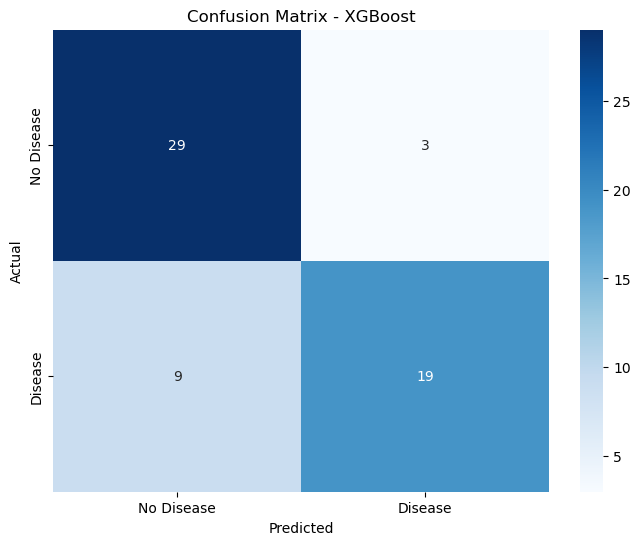

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [10]:
print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))

              precision    recall  f1-score   support

  No Disease       0.76      0.91      0.83        32
     Disease       0.86      0.68      0.76        28

    accuracy                           0.80        60
   macro avg       0.81      0.79      0.79        60
weighted avg       0.81      0.80      0.80        60



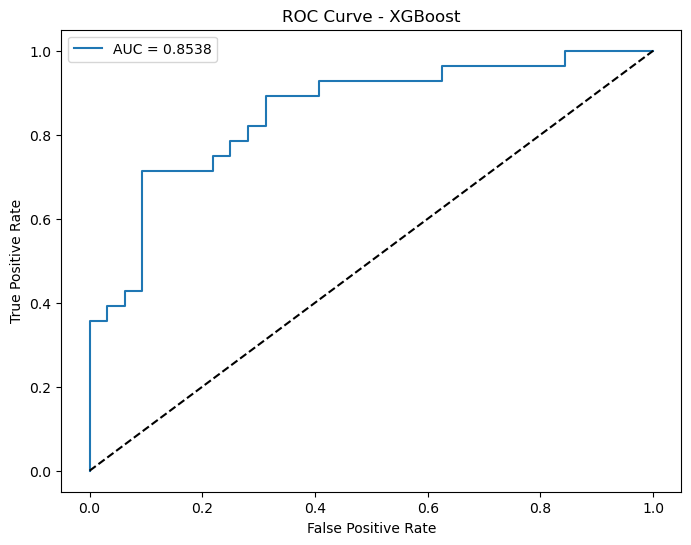

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {metrics["AUC"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()

### 6. Feature Importance

Feature Importance:
     feature  importance
2         cp    0.194176
12      thal    0.190082
11        ca    0.146502
1        sex    0.073003
9    oldpeak    0.066958
8      exang    0.063725
10     slope    0.056369
0        age    0.042449
4       chol    0.041925
3   trestbps    0.041878
6    restecg    0.040108
7     thalch    0.022622
5        fbs    0.020202


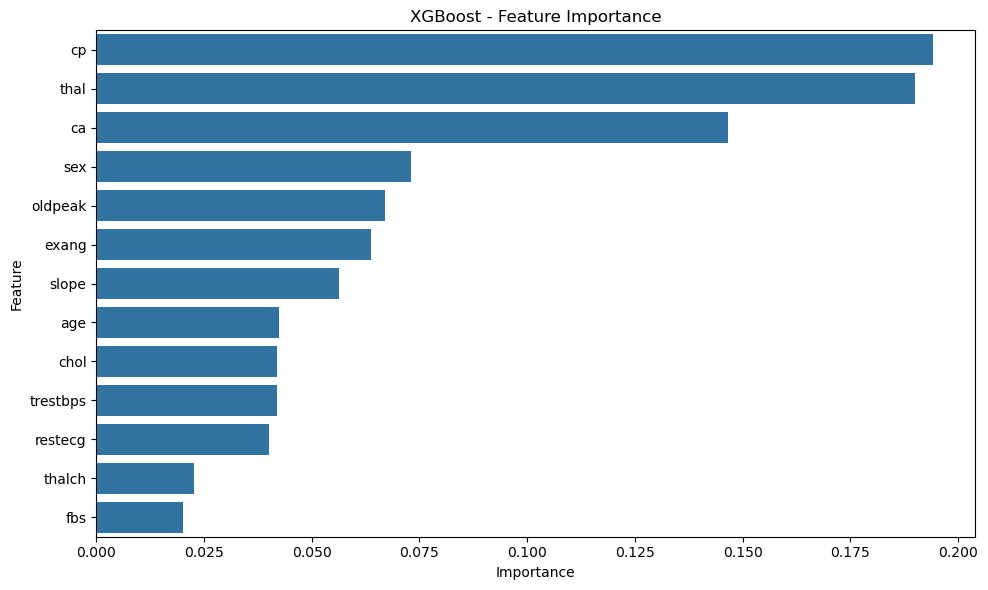

In [12]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost - Feature Importance')
plt.tight_layout()
plt.show()